# EE461P Term Project: Predicting Hotel Bookings on Expedia

### Group Members
1. Zander Tedjo (zbt86)
2. Alex Li
3. Shiv Lalapet
4. James Lu

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

#https://www.kaggle.com/c/expedia-hotel-recommendations


In [2]:
# Import original raw data
df_raw = pd.read_csv('expedia.csv')
print(df_raw.shape)
#print(df_raw.head())


             date_time  site_name  posa_continent  user_location_country  \
0  2014-08-11 07:46:59          2               3                     66   
1  2014-08-11 08:22:12          2               3                     66   
2  2014-08-11 08:24:33          2               3                     66   
3  2014-08-09 18:05:16          2               3                     66   
4  2014-08-09 18:08:18          2               3                     66   

   user_location_region  user_location_city  orig_destination_distance  \
0                   348               48862                  2234.2641   
1                   348               48862                  2234.2641   
2                   348               48862                  2234.2641   
3                   442               35390                   913.1932   
4                   442               35390                   913.6259   

   user_id  is_mobile  is_package  ...  srch_children_cnt srch_rm_cnt  \
0       12          0    

In [14]:
# Remove rows with missing values
df_clean = df_raw.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
print(df_clean.shape)

(24117894, 24)


In [15]:
#df_clean.to_csv('expedia_clean.csv', index=False)

In [53]:
# Resample randomly
from sklearn.utils import resample

size = 100000
df_resampled_random = resample(df_clean, replace=False, n_samples=size, random_state=42)    

print(df_resampled_random.shape)


(100000, 24)


In [54]:
df_resampled_random.to_csv('expedia_resampled_random.csv', index=False)

Text(0.5, 0, 'Hotel cluster')

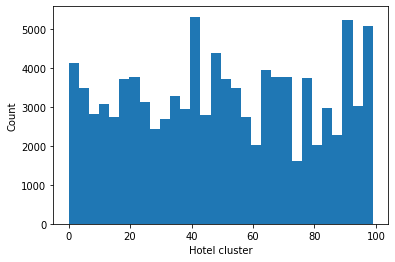

In [55]:
plt.hist(df_resampled_random['hotel_cluster'], bins=30)
plt.ylabel('Count')
plt.xlabel('Hotel cluster')

In [56]:
# Resample for equal class distributions
from sklearn.utils import resample

df_resampled_equal = pd.DataFrame()
class_size = 1000
classes = data_clean['hotel_cluster'].unique()

for c in classes:
    class_data = df_clean[df_clean.hotel_cluster == c]
    class_data_resampled = resample(class_data, replace=False, n_samples=class_size, random_state=42)    
    df_resampled_equal = pd.concat([df_resampled_equal, class_data_resampled])

print(df_resampled_equal.shape)

(100000, 24)


In [57]:
df_resampled_equal.to_csv('expedia_resampled_equal.csv', index=False)

In [88]:
# Drop unnecessary features

#df_dropped = df_resampled_random.copy()
df_dropped = df_resampled_equal.copy()

df_dropped = df_dropped.drop(['date_time'], axis=1)
df_dropped = df_dropped.drop(['user_id'], axis=1)
df_dropped = df_dropped.drop(['srch_ci'], axis=1)
df_dropped = df_dropped.drop(['srch_co'], axis=1)
df_dropped = df_dropped.drop(['site_name'], axis=1)

print(df_dropped.shape)
print(df_dropped.columns)

(100000, 20)
Index(['site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'is_mobile', 'is_package', 'channel',
       'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt',
       'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster'],
      dtype='object')


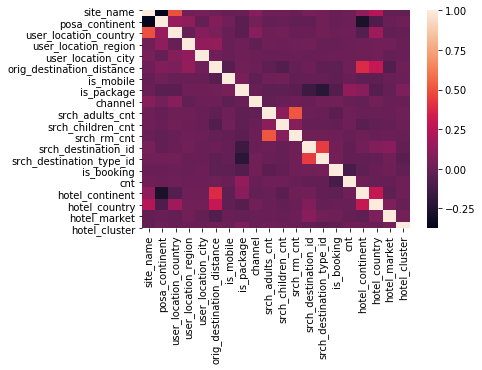

In [89]:
# Correlation heatmap
import seaborn as sns

corr = df_dropped.corr()
ax = sns.heatmap(corr)

In [93]:
# Get dummies for categorical features
data = pd.get_dummies(df_dropped)
print(data.shape)

(100000, 20)


In [94]:
# Test/train split
X = data.drop(['hotel_cluster'], axis=1)
Y = data['hotel_cluster']


In [97]:
# Select top K features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

n = 12
selector = SelectKBest(chi2, k=n)
X_new = selector.fit_transform(X, Y)

print(X_new.shape)
#print(X_new.columns)

(100000, 12)


In [100]:
# Normal data
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Feature selection data
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.25, random_state=42)


## Models

In [50]:
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred)

In [101]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve

reg = LogisticRegression(multi_class='multinomial', solver='saga')
reg.fit(X_train, y_train)

y_test_pred = reg.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy', accuracy)

#auc = roc_auc_score(y_test, y_test_pred, average='macro', multi_class='ovr')
auc = multiclass_roc_auc_score(y_test, y_test_pred)
print('AUC', auc)

C:\Users\zande\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy 0.0338
AUC 0.5119234058815081


In [70]:
# Xgboost
import xgboost as xgb

clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

y_test_pred = reg.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy', accuracy)

#auc = roc_auc_score(y_test, y_test_pred, multi_class='ovr')
auc = multiclass_roc_auc_score(y_test, y_test_pred)
print('AUC', auc)

Accuracy 0.03384
AUC 0.5119456330614248


In [ ]:
# Catboost


### Performances Notes
1. Larger data size is better, 100k better than 10k
2. No diff between logistic reg and xgboost


Logistic, random
Accuracy 0.04164
AUC 0.5039382643957466

Logistic, equal
Accuracy 0.03384
AUC 0.511945634765394

Logisitc, equal, 12 features
Accuracy 0.0338
AUC 0.5119234058815081